# Урок 6. Задача look-alike
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn.metrics import confusion_matrix,  f1_score, roc_auc_score, \
#                             precision_score, classification_report, precision_recall_curve

In [9]:
def corr_matrix(data, features):
    corr_matrix = np.round(data.loc[:, features].corr(), 2)
    corr_matrix[np.abs(corr_matrix) < 0.1] = 0
    
    plt.figure(figsize = (9,7))
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

In [4]:
DATA_PATH = "./materials/archive/train.csv"

In [65]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1


In [41]:
df.dropna(inplace=True)

In [45]:
X = df[['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
y = df['income_>50K']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [46]:
num_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', \
                'race', 'gender', 'native-country']
columns_with_nan = ['workclass', 'occupation', 'native-country']

In [39]:
df['workclass'].isna().value_counts()

False    41459
True      2498
Name: workclass, dtype: int64

In [54]:
ohe = OneHotEncoder(sparse=False)
rs = RobustScaler()
gbc = GradientBoostingClassifier(random_state=42)

ct = make_column_transformer((ohe, cat_features),
                             (rs, num_features))

pipe = make_pipeline(ct, gbc)

In [64]:
X['native-country'].loc[X['native-country'] == 'Holand-Netherlands']

40227    Holand-Netherlands
Name: native-country, dtype: object

In [61]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['age', 'fnlwgt',
                                                   'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                             

In [62]:
cv_score = cross_val_score(pipe, X, y, cv=6, scoring='f1_weighted')
cv_score.mean()

/home/leggard/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py"

nan

In [56]:
X_trans = ct.fit_transform(X)

pd.DataFrame(X_trans)

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.578947,1.557604,1.50,99999.0,0.0,4.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,-1.052632,0.549052,-0.50,0.0,0.0,-5.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.315789,-0.033786,0.75,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.105263,-0.563648,-1.50,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.631579,-0.240368,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.789474,-0.904876,0.75,0.0,0.0,2.0
40723,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.947368,-0.510969,-0.25,0.0,0.0,0.0
40724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.368421,0.162803,0.00,0.0,0.0,3.6
40725,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.473684,-0.665610,0.75,0.0,0.0,-1.0


In [57]:
params={'gradientboostingclassifier__learning_rate':[0.1, 0.075, 0.05, 0.025, 0.01],
        'gradientboostingclassifier__n_estimators':[50, 100, 200],
        'gradientboostingclassifier__min_samples_leaf':[1, 3, 5, 10],
        'gradientboostingclassifier__max_depth':[1, 2, 3, 4]
        }

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(X, y)
search.best_params_

/home/leggard/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "/home/leggard/.local/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py", line 748, i

KeyboardInterrupt: 

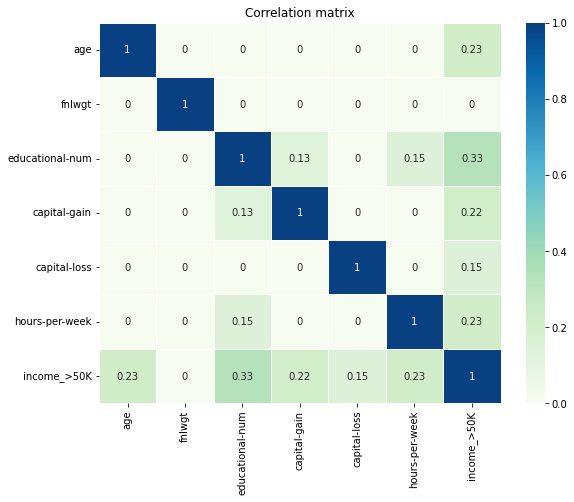

In [14]:
corr_matrix(df, df.columns[:])